<a href="https://colab.research.google.com/github/juliana-zh/machine_learning/blob/main/Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект "Космический корабль Титаник"

Задача бинарной классификации на наборе данных Spaceship Titanic.

Цель: предсказать, был ли пассажир перемещен в иное измерение аномалией.

Проект на Kaggle: https://www.kaggle.com/competitions/spaceship-titanic/overview

**План**:

1. Изучение исходных данных
2. Разведочный анализ данных (EDA - Exploratory Data Analysis)
3. Создание новых признаков
4. Обработка пропусков
5. Предобработка, масштабирование, кодирование данных
6. Кросс-валидация и предсказание с помощью ансамблей алгоритмов

## 1. Изучение исходных данных

### Библиотеки

In [2]:
! pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=f66737e31c0f7f6e5e3906dc68f25f4538cb060bef7341cd8de8060d189378d3
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [3]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [4]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
#import warnings
#warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve    # plot_confusion_matrix -> ConfusionMatrixDisplay, plot_roc_curve ->   RocCurveDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

### Данные

In [5]:
train = pd.read_csv('https://raw.githubusercontent.com/juliana-zh/machine_learning/main/datasets/spaceship_titanic/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/juliana-zh/machine_learning/main/datasets/spaceship_titanic/test.csv')

In [6]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

#### Признаки

- **PassengerId** - Уникальный идентификатор для каждого пассажира. Каждый идентификатор имеет форму gggg_pp, где gggg указывает группу, с которой путешествует пассажир, а pp - их номер в группе. Люди в группе часто являются членами семьи, но не всегда.
- **HomePlanet** - Планета, с которой отправился пассажир, обычно является его планетой постоянного проживания.
- **CryoSleep** - Указывает, выбрал ли пассажир быть помещенным в режим анабиоза на время рейса. Пассажиры, находящиеся в криосне, закрыты в своих каютах.
- **Cabin** - Номер каюты, в которой находится пассажир. Принимает вид deck/num/side, где side может быть либо P для левого, либо S для правого борта.
- **Destination** - Планета, на которую пассажир высадится.
- **Age** - Возраст пассажира.
- **VIP** - Оплатил ли пассажир специальное VIP-обслуживание во время рейса.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Сумма, которую пассажир потратил на каждое из множества роскошных сервисов космического корабля "Титаник".
- **Name** - Имя и фамилия пассажира
- **Transported** - Был ли пассажир перемещен в иное измерение. Целевой признак.

In [7]:
# Shape and preview
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [9]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


#### Пропуски

In [10]:
print('TRAIN SET MISSING VALUES:')
print(train.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

TEST SET MISSING VALUES:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Почти у каждого признака есть пропуски

#### Дубликаты

In [11]:
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


#### Виды признаков

В этом наборе данных есть 6 численных признаков ('Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'), 4 категориальных признака (исключая целевой) ('HomePlanet', 'CryoSleep', 'Destination', 'VIP') и 3 описательных/качественных признака ('PassengerId', 'Name', 'Cabin').

Число уникальных значений для каждого из признаков:

In [12]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

#### Типы данных

In [13]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Нам нужно будет преобразовать данные в числовые (int64 или float64), для обучения моделей. Так как они (в общем случае) не работают с текстом.

## 2. Разведочный анализ данных (EDA)

### Распределение целевого признака

Text(0.5, 1.0, 'Target distribution')

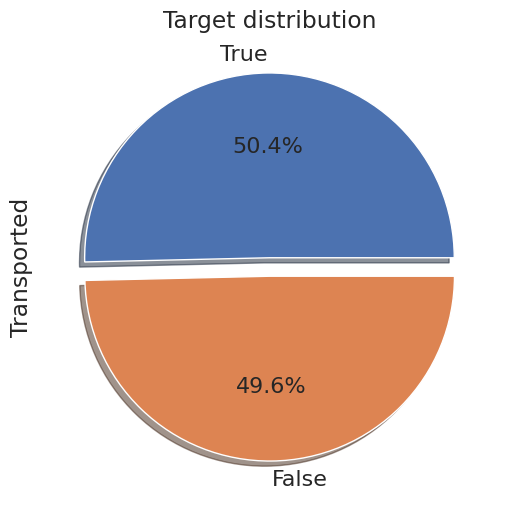

In [14]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
train['Transported'].value_counts().plot.pie(explode=[0.05,0.05], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

Целевой признак очень сбалансирован, поэтому нам не нужно рассматривать такие методы, как удаление объектов большего класса (undersampling) или клонирование объектов меньшего класса (oversampling).

### Численные признаки

Text(0.5, 0, 'Age (years)')

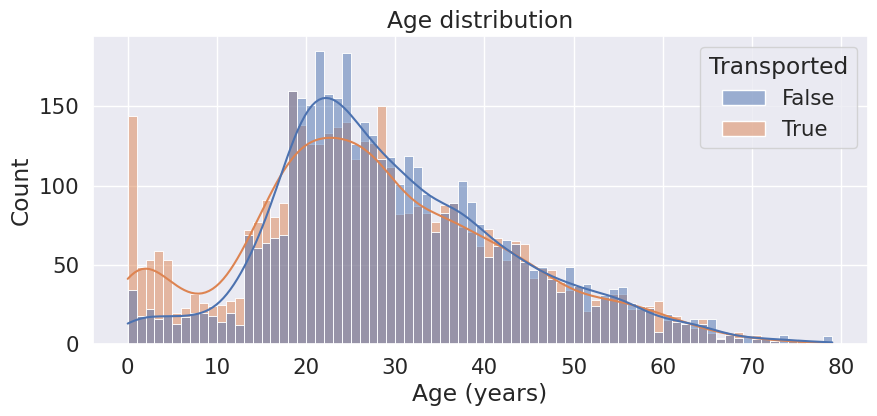

In [15]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

Заметим следующее:

- детей в возрасте от 0 до 18 лет больше транспортировали
- взрослых в возрасте 18-25 лет меньше транспортировали
- взрослые старше 25 лет: с одинаковой вероятностью быть спасенным или нет.

Идея:

Создать новый признак, указывающий на то, является ли пассажир ребенком,  молодым взрослым или старшим взрослым.

### Гистограммы для признаков трат на сервисы на космическом корабле

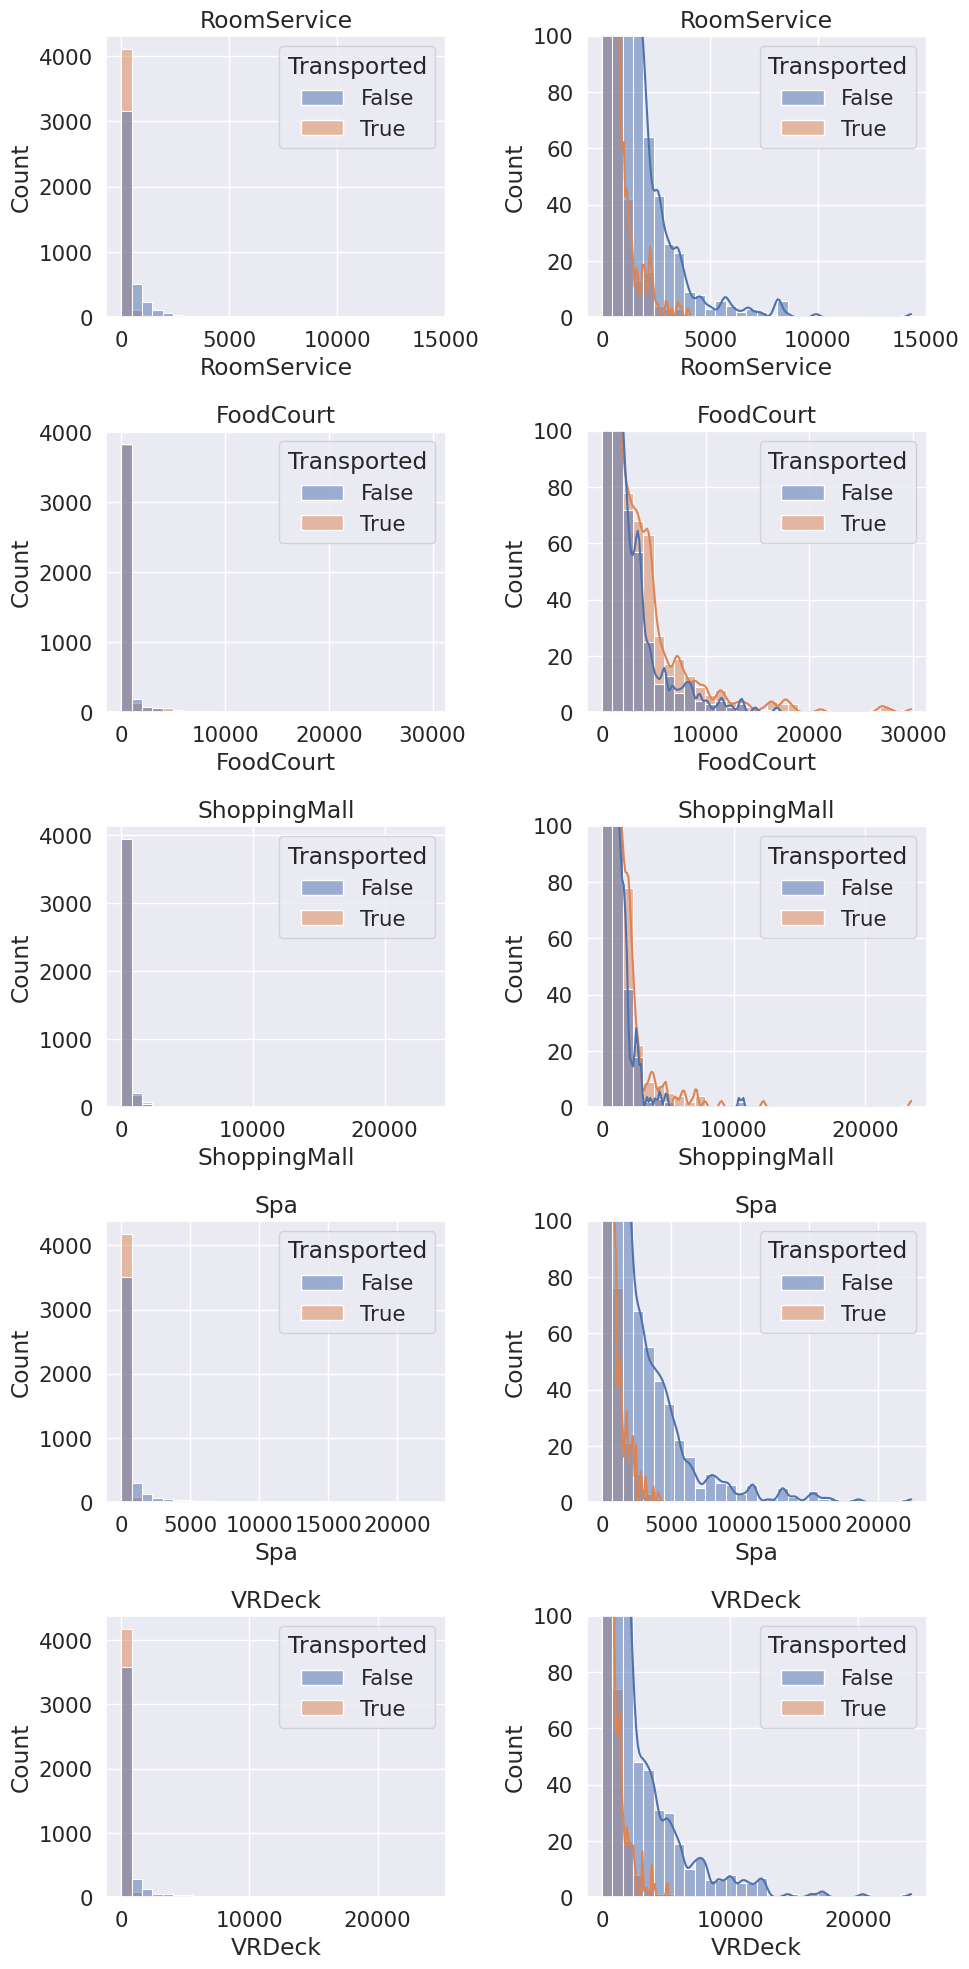

In [19]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)

    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

### Категориальные признаки

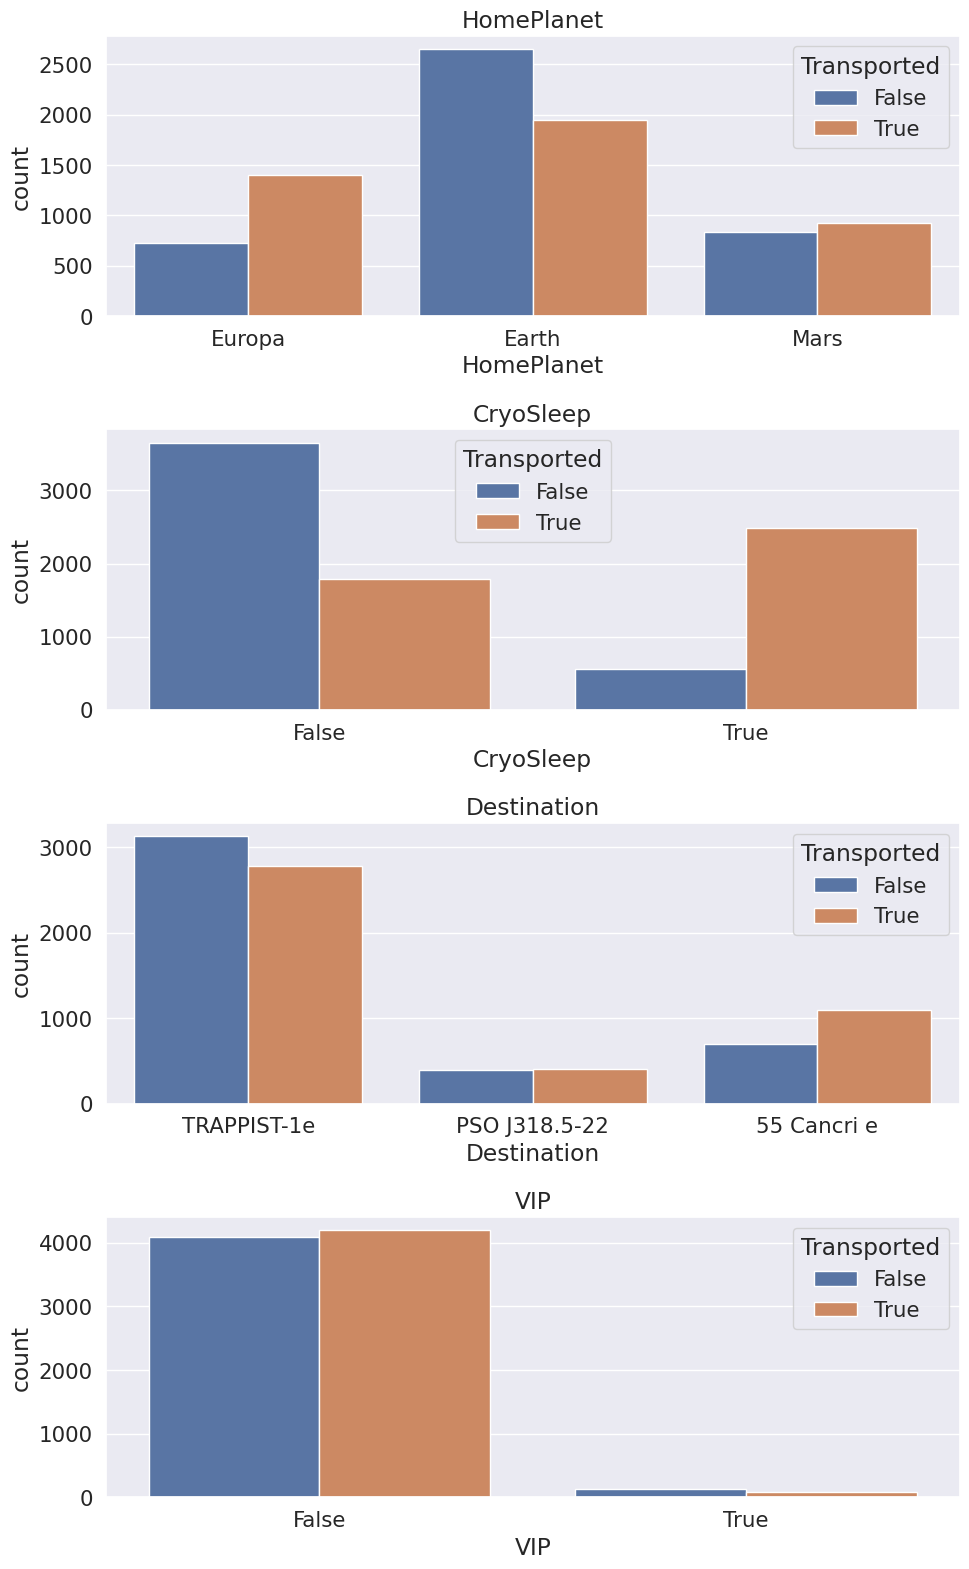

In [20]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

Заметим:

- признак VIP, по-видимому, не является значимым признаком:  распределение спасенных более или менее равное.
- напротив, 'CryoSleep' представляется очень важным признаком.

Идея:

Мы могли бы рассмотреть возможность удаления колонки 'VIP', чтобы предотвратить переобучение.

### Описательные признаки (признаки свойства, качества - qualitative )

Преобразуем в более полезные признаки

In [21]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


Заметим:

PassengerId обозначается как gggg_pp, где gggg указывает группу, с которой путешествует пассажир, а pp - его номер в группе.
Каюта обозначается как палуба/номер/борт, где борт может быть либо P (левый), либо S (правый).

Идеи:

- Мы можем извлечь группу и ее размер из 'PassengerId'.
- Мы можем извлечь палубу, номер и борт из 'Cabin'.
- Мы можем извлечь фамилию из функции 'Name', чтобы иметь возможность идентифицировать семьи.

## 3. Создание новых признаков

Философия создания новых признаков проста: **улучшение признаков способствует улучшению моделей.**

### Возраст

Создадим категориальный признак разделения по возрасту. Это будет полезно для заполнения недостающих значений, таких как расходы на сервисы в корабле в зависимости от возраста.

Text(0.5, 1.0, 'Age group distribution')

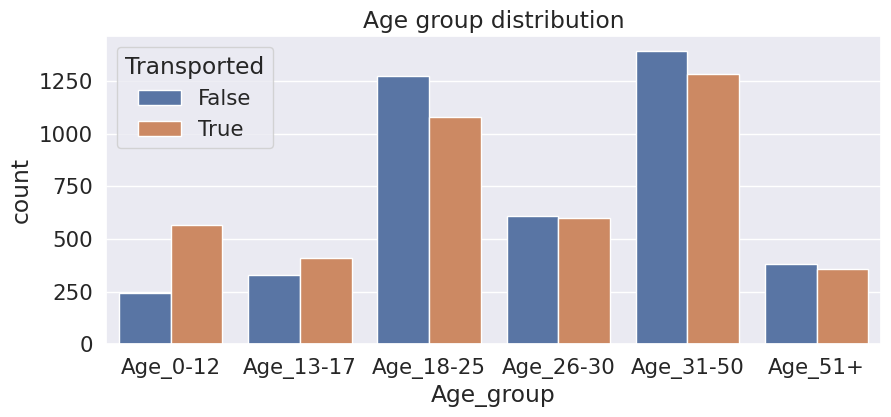

In [25]:
# New features - training set
train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

# New features - test set
test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

  ### Расходы на сервисы в корабле

In [30]:
train['Expenditure'] = train[exp_feats].sum(axis=1) # по выбранным столбцам суммирование для каждого из пассажиров
train['No_spending'] = (train['Expenditure']==0).astype(int)

In [35]:
# То же самое для test
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

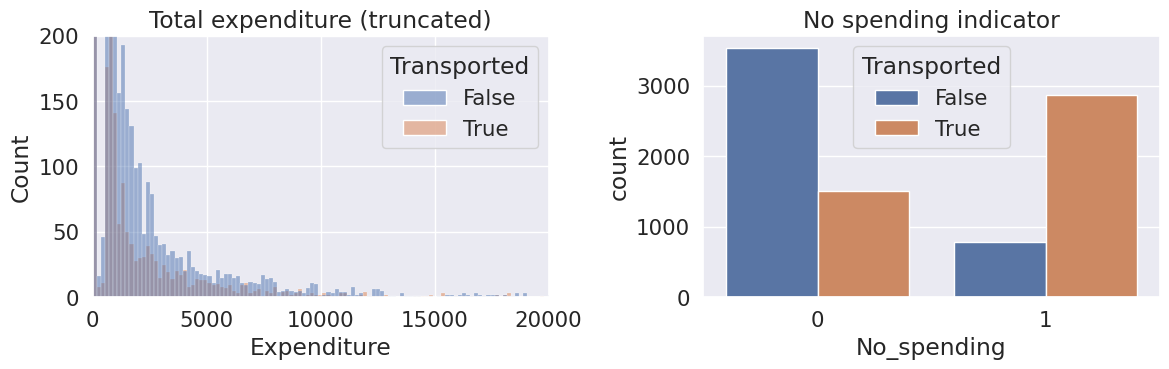

In [37]:
# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

### Группа пассажира

Получим группу пассажира и размер группы из данных.

In [42]:
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

In [45]:
# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


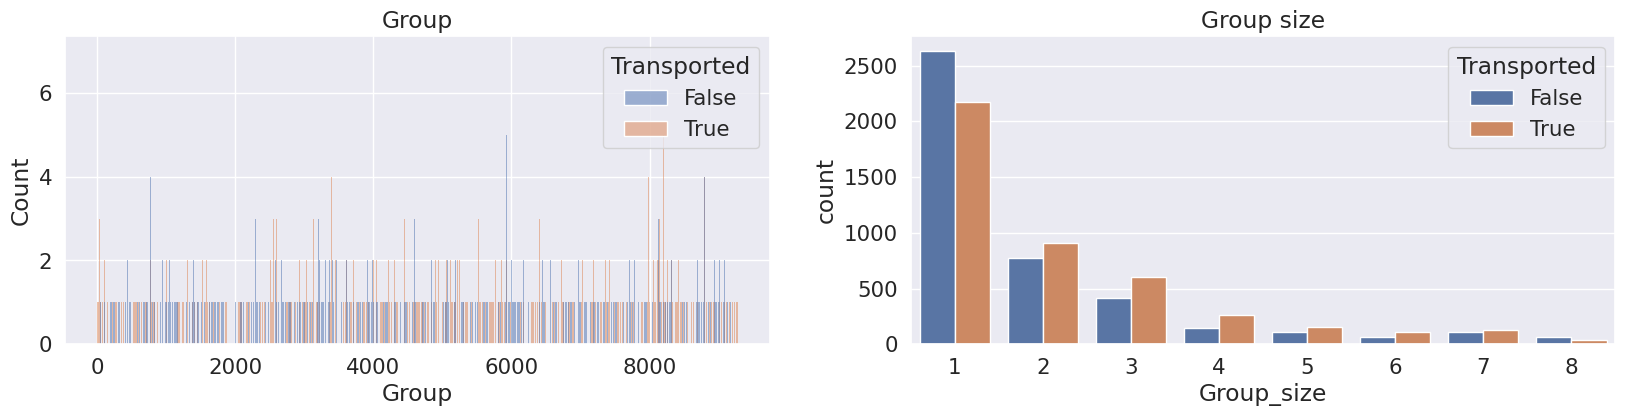

In [46]:
# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

Мы не можем использовать функцию Group в наших моделях, потому что множество значений имеет слишком большую мощность (6217).

С другой стороны, размер группы может быть полезным признаком. Фактически, мы можем еще больше сузить этот признак, создав колонку "Соло", которая отслеживает, путешествует ли кто-то самостоятельно или нет. На рисунке справа показано, что вероятность спасения группы размером = 1 меньше, чем группы размером > 1.

(0.0, 3000.0)

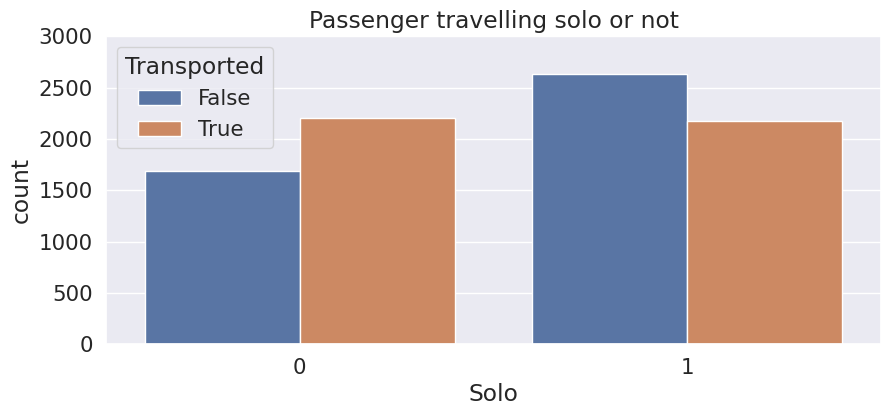

In [47]:
# New feature
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

### Местоположение кабины

Получим палубу, номер и борт из признака 'Cabin':

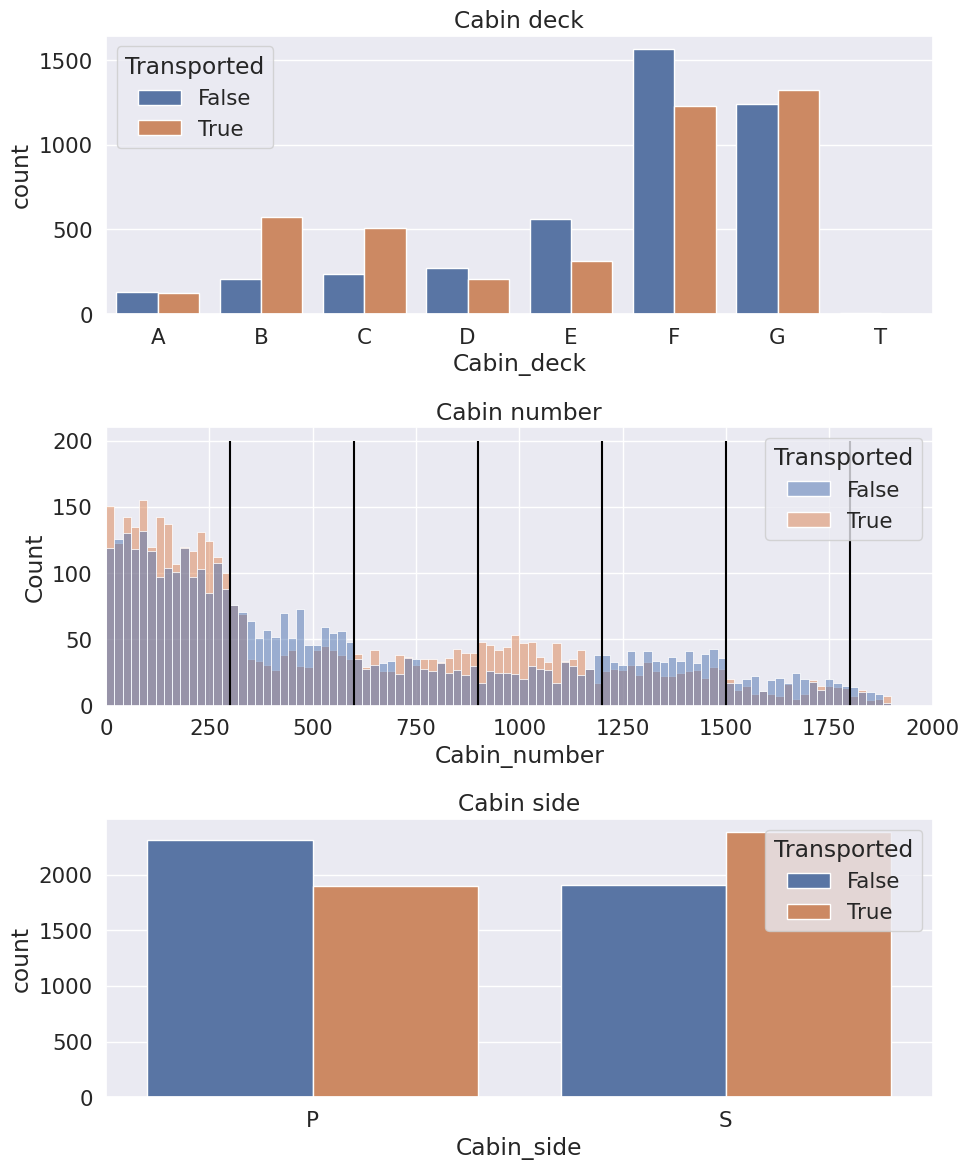

In [48]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

Заметим:

- Похоже, что значения признака 'Cabin_number' группируются в блоки из 300 номеров. Это значит, что мы можем сжать признак в новый: вместо числового создать категориальный, который будет говорить, в какой блок попал пассажир

- Возможно, что палуба 'T' - это выброс (только 5 объектов).

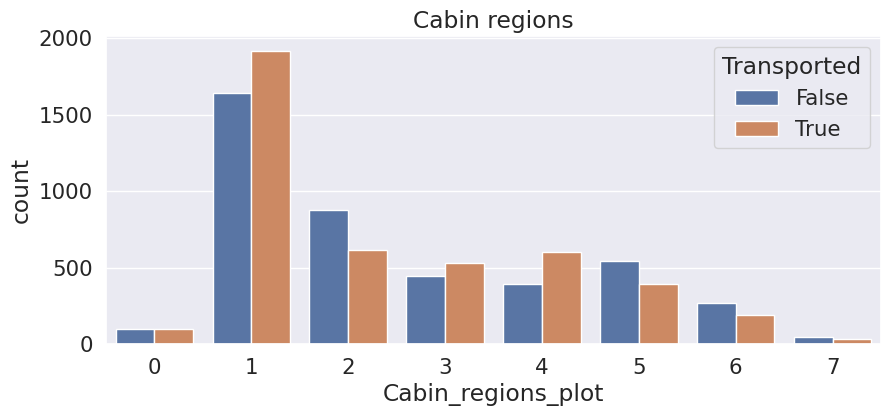

In [51]:
# New features - training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# New features - test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

### Фамилия

Получим размер семьи (приблизительно) через фамилию пассажиров

Text(0.5, 1.0, 'Family size')

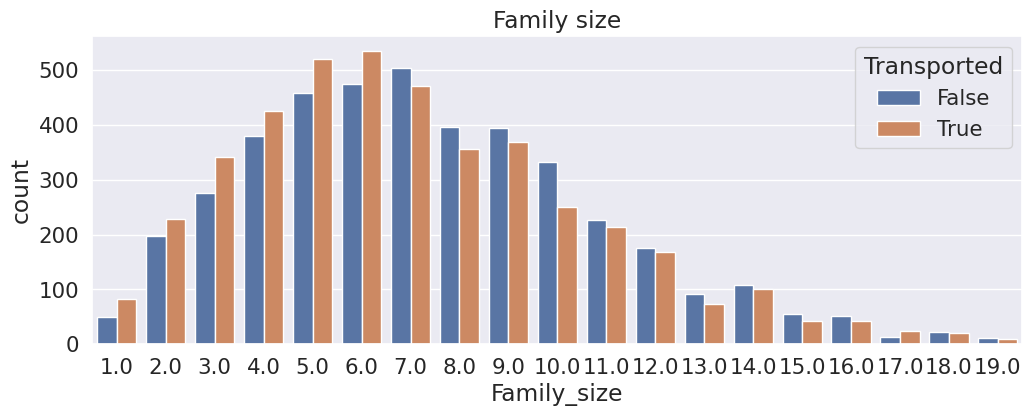

In [57]:
# Replace NaN's with outliers for now (so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

## 4. Обработка пропусков